The goal of this competition is to predict a Windows machine’s probability of getting infected by various families of malware, based on different properties of that machine. The telemetry data containing these properties and the machine infections was generated by combining heartbeat and threat reports collected by Microsoft's endpoint protection solution, Windows Defender.

Each row in this dataset corresponds to a machine, uniquely identified by a MachineIdentifier. HasDetections is the ground truth and indicates that Malware was detected on the machine. Using the information and labels in train.csv, you must predict the value for HasDetections for each machine in test.csv.

The sampling methodology used to create this dataset was designed to meet certain business constraints, both in regards to user privacy as well as the time period during which the machine was running. Malware detection is inherently a time-series problem, but it is made complicated by the introduction of new machines, machines that come online and offline, machines that receive patches, machines that receive new operating systems, etc. While the dataset provided here has been roughly split by time, the complications and sampling requirements mentioned above may mean you may see imperfect agreement between your cross validation, public, and private scores! Additionally, this dataset is not representative of Microsoft customers’ machines in the wild; it has been sampled to include a much larger proportion of malware machines.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from sklearn.experimental import enable_hist_gradient_boosting
import sklearn.ensemble as ske
from sklearn.model_selection import train_test_split
from sklearn import tree, linear_model
from sklearn.feature_selection import SelectFromModel
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

In [2]:
# set up display area to show dataframe in jupyter qtconsole
#pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# We need to explicitly specify data types when reading csv, otherwise it is very memory consuming
# and we will get the warning "Specify dtype option on import or set low_memory=False"
# So, we will manually defined the data types

# P.S. I have loaded the sample data and exported train_data.dtypes
# these are the data types for fast loading

datatypes = {
    'ProductName': str,
    'EngineVersion': str,
    'AppVersion': str,
    'AvSigVersion': str,
    'IsBeta': np.int8,
    'RtpStateBitfield': str,
    'IsSxsPassiveMode': np.int8,
    'DefaultBrowsersIdentifier': str,
    'AVProductStatesIdentifier': str,
    'AVProductsInstalled': str,
    'AVProductsEnabled': str,
    'HasTpm': np.int8,
    'CountryIdentifier': str,
    'CityIdentifier': str,
    'OrganizationIdentifier': str,
    'GeoNameIdentifier': str,
    'LocaleEnglishNameIdentifier': str,
    'Platform': str,
    'Processor': str,
    'OsVer': str,
    'OsBuild': str,
    'OsSuite': str,
    'OsPlatformSubRelease': str,
    'OsBuildLab': str,
    'SkuEdition': str,
    'IsProtected': str,
    'AutoSampleOptIn': np.int8,
    'PuaMode': str,
    'SMode': str,
    'IeVerIdentifier': str,
    'SmartScreen': str,
    'Firewall': str,
    'UacLuaenable': str,
    'Census_MDC2FormFactor': str,
    'Census_DeviceFamily': str,
    'Census_OEMNameIdentifier': str,
    'Census_OEMModelIdentifier': str, 
    'Census_ProcessorCoreCount': str,
    'Census_ProcessorManufacturerIdentifier': str,
    'Census_ProcessorModelIdentifier': str,
    'Census_ProcessorClass': str,
    'Census_PrimaryDiskTotalCapacity': np.float64,
    'Census_PrimaryDiskTypeName': str,
    'Census_SystemVolumeTotalCapacity': np.float64,
    'Census_HasOpticalDiskDrive': np.int8,
    'Census_TotalPhysicalRAM': np.float64,
    'Census_ChassisTypeName': str,
    'Census_InternalPrimaryDiagonalDisplaySizeInInches': str,
    'Census_InternalPrimaryDisplayResolutionHorizontal': str,
    'Census_InternalPrimaryDisplayResolutionVertical': str,
    'Census_PowerPlatformRoleName': str,
    'Census_InternalBatteryType': str,
    'Census_InternalBatteryNumberOfCharges': str,
    'Census_OSVersion': str,
    'Census_OSArchitecture': str,
    'Census_OSBranch': str,
    'Census_OSBuildNumber': str,
    'Census_OSBuildRevision': str,
    'Census_OSEdition': str,
    'Census_OSSkuName': str,
    'Census_OSInstallTypeName': str,
    'Census_OSInstallLanguageIdentifier': str,
    'Census_OSUILocaleIdentifier': str,
    'Census_OSWUAutoUpdateOptionsName': str,
    'Census_IsPortableOperatingSystem': np.int8,
    'Census_GenuineStateName': str,
    'Census_ActivationChannel': str,
    'Census_IsFlightingInternal': str,
    'Census_IsFlightsDisabled': str,
    'Census_FlightRing': str,
    'Census_ThresholdOptIn': str,
    'Census_FirmwareManufacturerIdentifier': str,
    'Census_FirmwareVersionIdentifier': str,
    'Census_IsSecureBootEnabled': np.int8,
    'Census_IsWIMBootEnabled': str,
    'Census_IsVirtualDevice': str,
    'Census_IsTouchEnabled': np.int8,
    'Census_IsPenCapable': np.int8,
    'Census_IsAlwaysOnAlwaysConnectedCapable': str,
    'Wdft_IsGamer': str,
    'Wdft_RegionIdentifier': str,
    'HasDetections': np.int8
}

full_features = pd.read_csv("https://raw.githubusercontent.com/nugzar/mics-w207/master/final/train.csv", dtype=datatypes, index_col="MachineIdentifier")

In [4]:
print (full_features.shape)

(180000, 82)


In [5]:
# Optional
# For speeding up the processes, we will shuffle the data and take only 200,000 rows. Otherwise it will take quite a bit

# Shuffle the data

shuffle = np.random.permutation(np.arange(full_features.shape[0]))[:200000]
indexes = full_features.index[shuffle]

full_features = full_features.loc[indexes,:]

print (full_features.shape)

(180000, 82)


In [6]:
# Checking the columns with the most NULL values
print((full_features.isnull().sum()).sort_values(ascending=False).head(20))

PuaMode                                  179953
Census_ProcessorClass                    179232
DefaultBrowsersIdentifier                171092
Census_IsFlightingInternal               149456
Census_InternalBatteryType               127786
Census_ThresholdOptIn                    114309
Census_IsWIMBootEnabled                  114145
SmartScreen                               64360
OrganizationIdentifier                    55367
SMode                                     10972
CityIdentifier                             6533
Wdft_IsGamer                               6255
Wdft_RegionIdentifier                      6255
Census_InternalBatteryNumberOfCharges      5382
Census_FirmwareManufacturerIdentifier      3704
Census_FirmwareVersionIdentifier           3237
Census_IsFlightsDisabled                   3201
Census_OEMModelIdentifier                  2065
Census_OEMNameIdentifier                   1926
Firewall                                   1826
dtype: int64


In [7]:
full_features['PuaMode'].unique()

array([nan, 'on'], dtype=object)

In [8]:
full_features['Census_IsFlightingInternal'].unique()

array([nan, '0.0'], dtype=object)

In [9]:
full_features['Census_InternalBatteryType'].unique()

array([nan, 'lion', 'li-i', 'li p', 'liio', '#', 'lip', 'real', 'li',
       'nimh', 'bq20', 'pbac', 'unkn', 'vbox', 'lit', 'ithi', '4lio',
       'lgi0', '4cel', 'icp3', 'ca48', 'lipp', 'lipo', 'ram', 'asmb',
       'batt', 'lhp0', 'li-p'], dtype=object)

In [10]:
full_features['Census_ThresholdOptIn'].unique()

array([nan, '0.0', '1.0'], dtype=object)

In [11]:
full_features['Census_IsWIMBootEnabled'].unique()

array([nan, '0.0'], dtype=object)

In [12]:
full_features['SMode'].unique()

array(['0.0', nan, '1.0'], dtype=object)

In [13]:
full_features['OrganizationIdentifier'].unique()

array(['27.0', '18.0', nan, '48.0', '8.0', '11.0', '10.0', '2.0', '50.0',
       '46.0', '51.0', '37.0', '52.0', '49.0', '31.0', '36.0', '4.0',
       '14.0', '32.0', '12.0', '28.0', '20.0', '42.0', '40.0', '33.0',
       '16.0', '47.0', '21.0', '39.0', '5.0', '1.0', '3.0', '6.0', '19.0',
       '29.0', '44.0', '26.0', '22.0', '45.0', '35.0'], dtype=object)

In [14]:
full_features['Wdft_IsGamer'].unique()

array(['0.0', '1.0', nan], dtype=object)

In [15]:
full_features['Wdft_RegionIdentifier'].unique()

array(['11.0', '4.0', '10.0', '1.0', '15.0', '9.0', '3.0', '6.0', '13.0',
       '7.0', nan, '12.0', '8.0', '14.0', '2.0', '5.0'], dtype=object)

In [16]:
full_features['CityIdentifier'].unique()

array(['25179.0', '161946.0', '152917.0', ..., '118361.0', '70263.0',
       '137259.0'], dtype=object)

In [17]:
full_features['Census_InternalBatteryNumberOfCharges'].unique()

array(['0.0', '4294967295.0', nan, ..., '18043.0', '20792.0', '7275.0'],
      dtype=object)

In [18]:
# Cleaning up some data

# PuaMode - Potentially Unwanted Applications, if NA, then it is disabled. 99% are NA. So, better to drop it
# Census_ProcessorClass - According to the description - "No longer maintained and updated"
# DefaultBrowsersIdentifier - Almost all values are empty. Therefore we will drop this column
# Census_IsFlightingInternal - whether this is internal or "external" testing ring. Column mostly unused. Will have to drop it
# Census_InternalBatteryType - comtains mostly garbage. Besides, it should not be relevant to attack surface.
# Census_ThresholdOptIn - also mostly unused. Googled it and Threshold was used in first versions of Windows 10. Looks like unused now
# Census_IsWIMBootEnabled - Is it possible to boot from Windows Image? Not relevant to identification of the attacks when 70% of data is emtpy
# SmartScreen - Whether smart screen in explorer is enabled. Should be important. "ExistsNotSet" when null, according to the description
# SMode - Quite relevant field. Will be keeping it
# OrganizationIdentifier - Attacks by organizations should be analyzed. If not filled, will assign "0". 
# Census_InternalBatteryNumberOfCharges - Not relevant. Will drop this column in order not to overtrain
# Census_OSSkuName -  OS edition friendly name (currently Windows only). - Can be removed. Duplicate field
# Census_ChassisTypeName - Census_MDC2FormFactor gives better information. Let's remove this field

#full_features['PuaMode'] = full_features['PuaMode'].fillna('off')
#full_features['SmartScreen'] = full_features['SmartScreen'].fillna('ExistsNotSet')
#full_features['SMode'] = full_features['SMode'].fillna('0').astype('int8')
#full_features['OrganizationIdentifier'] = full_features['OrganizationIdentifier'].fillna('0').astype('int32')
#full_features['Wdft_IsGamer'] = full_features['Wdft_IsGamer'].fillna('0').astype('int8')
#full_features['Wdft_RegionIdentifier'] = full_features['Wdft_RegionIdentifier'].fillna('0').astype('int32')
#full_features['CityIdentifier'] = full_features['CityIdentifier'].fillna('0').astype('int32')

#full_features = full_features.drop([
#    'PuaMode',
#    'Census_OSEdition',
#    'Census_ProcessorClass',
#    'DefaultBrowsersIdentifier',
#    'Census_IsFlightingInternal',
#    'Census_InternalBatteryType'], axis=1)

In [19]:
# Now let us check the string columns

string_columns = []

for colname in full_features.dtypes.keys():
    if full_features[colname].dtypes.name == "object":
        string_columns.append(colname)
        
string_columns

['ProductName',
 'EngineVersion',
 'AppVersion',
 'AvSigVersion',
 'RtpStateBitfield',
 'DefaultBrowsersIdentifier',
 'AVProductStatesIdentifier',
 'AVProductsInstalled',
 'AVProductsEnabled',
 'CountryIdentifier',
 'CityIdentifier',
 'OrganizationIdentifier',
 'GeoNameIdentifier',
 'LocaleEnglishNameIdentifier',
 'Platform',
 'Processor',
 'OsVer',
 'OsBuild',
 'OsSuite',
 'OsPlatformSubRelease',
 'OsBuildLab',
 'SkuEdition',
 'IsProtected',
 'PuaMode',
 'SMode',
 'IeVerIdentifier',
 'SmartScreen',
 'Firewall',
 'UacLuaenable',
 'Census_MDC2FormFactor',
 'Census_DeviceFamily',
 'Census_OEMNameIdentifier',
 'Census_OEMModelIdentifier',
 'Census_ProcessorCoreCount',
 'Census_ProcessorManufacturerIdentifier',
 'Census_ProcessorModelIdentifier',
 'Census_ProcessorClass',
 'Census_PrimaryDiskTypeName',
 'Census_ChassisTypeName',
 'Census_InternalPrimaryDiagonalDisplaySizeInInches',
 'Census_InternalPrimaryDisplayResolutionHorizontal',
 'Census_InternalPrimaryDisplayResolutionVertical',
 'C

In [20]:
full_features[string_columns].head(10)

,ProductName,EngineVersion,AppVersion,AvSigVersion,RtpStateBitfield,DefaultBrowsersIdentifier,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,Platform,Processor,OsVer,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,SkuEdition,IsProtected,PuaMode,SMode,IeVerIdentifier,SmartScreen,Firewall,UacLuaenable,Census_MDC2FormFactor,Census_DeviceFamily,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_ProcessorClass,Census_PrimaryDiskTypeName,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSArchitecture,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_IsFlightsDisabled,Census_FlightRing,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier
MachineIdentifier,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
77513290b6cf9cefa5ec4572e76feced,win8defender,1.1.15100.1,4.18.1806.18062,1.273.315.0,7.0,NaN,53447.0,1.0,1.0,122,25179.0,27.0,175.0,94,windows10,x64,10.0.0.0,17134,768,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,1.0,NaN,0.0,137.0,RequireAdmin,1.0,1.0,Notebook,Windows.Desktop,4730.0,311095.0,1.0,1.0,638.0,NaN,HDD,Notebook,15.5,1366.0,768.0,Mobile,NaN,0.0,10.0.17134.191,amd64,rs4_release,17134,191,Core,CORE,UUPUpgrade,14.0,49,FullAuto,IS_GENUINE,Retail,NaN,0.0,Retail,NaN,556.0,7271.0,NaN,0.0,0.0,0.0,11.0
342328be941ccf2f3b1b3132994418f1,win8defender,1.1.15100.1,4.18.1806.18062,1.273.1341.0,7.0,NaN,53447.0,1.0,1.0,35,161946.0,18.0,277.0,75,windows10,x64,10.0.0.0,16299,768,rs3,16299.431.amd64fre.rs3_release_svc_escrow.1805...,Home,1.0,NaN,0.0,117.0,RequireAdmin,1.0,1.0,Notebook,Windows.Desktop,2206.0,229568.0,2.0,5.0,3427.0,NaN,HDD,Notebook,15.5,1366.0,768.0,Mobile,lion,0.0,10.0.16299.431,amd64,rs3_release_svc_escrow,16299,431,Core,CORE,Update,8.0,31,Notify,IS_GENUINE,Retail,0.0,0.0,Retail,0.0,554.0,33006.0,0.0,0.0,0.0,0.0,4.0
32fd9ccd50fc298891047840caf5696a,win8defender,1.1.15100.1,4.12.16299.15,1.273.1420.0,7.0,NaN,41571.0,2.0,1.0,41,152917.0,18.0,52.0,217,windows10,x64,10.0.0.0,16299,768,rs3,16299.431.amd64fre.rs3_release_svc_escrow.1805...,Home,1.0,NaN,0.0,117.0,RequireAdmin,1.0,1.0,Notebook,Windows.Desktop,2668.0,171149.0,2.0,5.0,1985.0,NaN,HDD,Notebook,13.9,1366.0,768.0,Mobile,li-i,0.0,10.0.16299.547,amd64,rs3_release_svc_escrow,16299,547,CoreSingleLanguage,CORE_SINGLELANGUAGE,Upgrade,9.0,34,UNKNOWN,IS_GENUINE,OEM:DM,NaN,0.0,Retail,0.0,628.0,26318.0,0.0,0.0,0.0,0.0,10.0
eaa652b8478c2ee74e0638822f3e98b3,win8defender,1.1.15300.5,4.18.1807.18075,1.275.1140.0,7.0,3195.0,53447.0,1.0,1.0,195,102241.0,27.0,277.0,75,windows10,x64,10.0.0.0,15063,768,rs2,15063.0.amd64fre.rs2_release.170317-1834,Home,1.0,NaN,0.0,105.0,NaN,1.0,1.0,Notebook,Windows.Desktop,525.0,331058.0,4.0,5.0,2393.0,NaN,HDD,Notebook,13.9,1366.0,768.0,Mobile,NaN,0.0,10.0.15063.250,amd64,rs2_release,15063,250,CoreSingleLanguage,CORE_SINGLELANGUAGE,Other,8.0,31,Notify,IS_GENUINE,OEM:DM,NaN,0.0,Unknown,NaN,142.0,69312.0,NaN,0.0,0.0,0.0,1.0
f88c61e3840a81375b2e8663f8029a22,win8defender,1.1.14800.3,4.12.16299.15,1.267.777.0,7.0,NaN,53447.0,1.0,1.0,149,80890.0,27.0,181.0,56,windows10,x64,10.0.0.0,16299,256,rs3,16299.15.amd64fre.rs3_release.170928-1534,Pro,1.0,NaN,0.0,135.0,RequireAdmin,1.0,1.0,Noteb

At first glance at the data, it becomes obvious, that the stings are either classifiers, or versions that contain 4 classifiers in them. So. in order to use the algorithms that support only numeric values we will convert classifiers like "ProductName" to integer range and the fields like AppVersion

In [21]:
def df_replacevalues(df, colname, oldvalues, newvalues, topvalue):
    # First, we need to get the most frequent value of the column
    #topvalue = df[colname].value_counts().idxmax() # Decided yo specify explicitly, so commenting out
    
    # Replace NaN values with the popular value
    df[colname].fillna(topvalue, inplace=True)
    
    # We need to make sure no other value than oldvalues exists
    indexes = df[~df[colname].isin(oldvalues)].index
    
    # If the "Garbage" values are more than 1%, then raise an error
    if len(indexes) > len(df) / 100:
        raise Exception("Not all neccessary values are present in oldvalues array")
    
    # Replace "Garbage" with the top value
    df.loc[indexes,[colname]] = topvalue
    
    print ("Previous values", df[colname].unique())
    df[colname] = pd.to_numeric(df[colname].replace(oldvalues, newvalues), errors='raise', downcast='integer')
    print ("New values", df[colname].unique())
    
#full_features["Platform"].unique()
#full_features["Platform"].value_counts()
#full_features[~full_features["ProductName"].isin(['win8defender', 'mse'])].index

Standard convertor accuracy was only 57% when the feature values of data type string. 

Replaced all the string values in the following features to numbers and used OrdinalEncoder, which increased the accuracy 5-10%.

- ProductName
- Platform
- Processor
- OsPlatformSubRelease
- SkuEdition
- SmartScreen
- Census_MDC2FormFactor
- Census_DeviceFamily
- Census_PrimaryDiskTypeName
- Census_ChassisTypeName
- Census_PowerPlatformRoleName
- Census_OSArchitecture
- Census_OSBranch
- Census_OSSkuName
- Census_MDC2FormFactor
- Census_DeviceFamily
- Census_PrimaryDiskTypeName
- Census_ChassisTypeName
- Census_PowerPlatformRoleName
- Census_OSArchitecture
- Census_OSBranch
- Census_OSSkuName
- Census_OSInstallTypeName
- Census_OSWUAutoUpdateOptionsName
- Census_InternalBatteryType
- Census_GenuineStateName
- Census_ActivationChannel
- Census_FlightRing
- Census_OSEdition

In [22]:
print(full_features["ProductName"].value_counts())

colname = "ProductName"
oldvalues = ['win8defender','mse','mseprerelease']
newvalues = [1,2,2]

df_replacevalues(full_features, colname, oldvalues, newvalues, 'win8defender')

win8defender     178127
mse                1869
mseprerelease         4
Name: ProductName, dtype: int64
Previous values ['win8defender' 'mse' 'mseprerelease']
New values [1 2]


In [23]:
print(full_features["Platform"].value_counts())

colname = "Platform"
oldvalues = ['windows10','windows7','windows8','windows2016','Undefined']
newvalues = [10,7,8,2016,-1]

df_replacevalues(full_features, colname, oldvalues, newvalues,'Undefined')

windows10      173941
windows8         3910
windows7         1845
windows2016       304
Name: Platform, dtype: int64
Previous values ['windows10' 'windows7' 'windows8' 'windows2016']
New values [  10    7    8 2016]


In [24]:
print(full_features["Processor"].value_counts())

colname = "Processor"
oldvalues = ['x64','arm64','x86']
newvalues = [i+1 for i in range(len(oldvalues))]

df_replacevalues(full_features, colname, oldvalues, newvalues, 'x64')

x64      163599
x86       16394
arm64         7
Name: Processor, dtype: int64
Previous values ['x64' 'x86' 'arm64']
New values [1 3 2]


In [25]:
colname = "OsPlatformSubRelease"

print(full_features[colname].value_counts())

oldvalues = ['rs4','rs3','rs2','rs1','windows7','windows8.1','th1','th2','prers5','Unknown']
newvalues = [504,503,502,501,        407,408,                201,202,     505,     0]

df_replacevalues(full_features, colname, oldvalues, newvalues, 'Unknown')

rs4           78931
rs3           50578
rs2           15957
rs1           14773
th2            8119
th1            5462
windows8.1     3910
windows7       1845
prers5          425
Name: OsPlatformSubRelease, dtype: int64
Previous values ['rs4' 'rs3' 'rs2' 'rs1' 'th2' 'th1' 'windows7' 'windows8.1' 'prers5']
New values [504 503 502 501 202 201 407 408 505]


In [26]:
colname = "SkuEdition"

print(full_features[colname].value_counts())

oldvalues = ['Pro','Home','Invalid','Enterprise LTSB','Enterprise','Education','Cloud','Server']
newvalues = [55,52,0,71,70,20,90,80]

df_replacevalues(full_features, colname, oldvalues, newvalues, 'Invalid')

Home               110835
Pro                 65462
Invalid              1583
Education             812
Enterprise            696
Enterprise LTSB       423
Cloud                 120
Server                 69
Name: SkuEdition, dtype: int64
Previous values ['Home' 'Pro' 'Invalid' 'Enterprise LTSB' 'Education' 'Enterprise' 'Cloud'
 'Server']
New values [52 55  0 71 20 70 90 80]


In [27]:
colname = "SmartScreen"

print(full_features[colname].value_counts())

oldvalues = ['Off','off','OFF','On','on','Warn','Prompt','ExistsNotSet','Block','RequireAdmin']
newvalues = [0,0,0,1,1,2,3,4,5,6]

df_replacevalues(full_features, colname, oldvalues, newvalues, 'ExistsNotSet')

RequireAdmin    86940
ExistsNotSet    21019
Off              3718
Warn             2754
Prompt            695
Block             446
off                36
On                 12
&#x01;              7
&#x02;              7
on                  6
Name: SmartScreen, dtype: int64
Previous values ['RequireAdmin' 'ExistsNotSet' 'Warn' 'Off' 'Prompt' 'Block' 'off' 'on'
 'On']
New values [6 4 2 0 3 5 1]


In [28]:
colname = "Census_MDC2FormFactor"

print(full_features[colname].value_counts())

oldvalues = ['Desktop','Notebook','Detachable','PCOther','AllInOne','Convertible','SmallTablet','LargeTablet','SmallServer','LargeServer','MediumServer','ServerOther','Other']
newvalues = [i+1 for i in range(len(oldvalues))]

df_replacevalues(full_features, colname, oldvalues, newvalues, 'Other')

Notebook        115207
Desktop          39669
Convertible       8109
Detachable        6078
AllInOne          5914
PCOther           2817
LargeTablet       1303
SmallTablet        621
SmallServer        186
MediumServer        75
LargeServer         19
ServerOther          2
Name: Census_MDC2FormFactor, dtype: int64
Previous values ['Notebook' 'AllInOne' 'Desktop' 'SmallTablet' 'Convertible' 'LargeTablet'
 'Detachable' 'PCOther' 'MediumServer' 'SmallServer' 'ServerOther'
 'LargeServer']
New values [ 2  5  1  7  6  8  3  4 11  9 12 10]


In [29]:
# Census_DeviceFamily ['Windows.Desktop' 'Windows.Server' 'Windows']

colname = "Census_DeviceFamily"

print(full_features[colname].value_counts())

oldvalues = ['Windows.Desktop','Windows.Server','Windows']
#newvalues = [i+1 for i in range(len(oldvalues))]
# Windows = Windows.Desktop
newvalues = [1,2,1]
    
df_replacevalues(full_features, colname, oldvalues, newvalues, 'Windows.Desktop')

Windows.Desktop    179696
Windows.Server        304
Name: Census_DeviceFamily, dtype: int64
Previous values ['Windows.Desktop' 'Windows.Server']
New values [1 2]


In [30]:
# Census_PrimaryDiskTypeName ['HDD' 'SSD' 'UNKNOWN' 'Unspecified' nan]

colname = "Census_PrimaryDiskTypeName"

print(full_features[colname].value_counts())

oldvalues = ['HDD','SSD','UNKNOWN','Unspecified']
newvalues = [1,2,3,3]

df_replacevalues(full_features, colname, oldvalues, newvalues, 'Unspecified')

HDD            117029
SSD             49818
UNKNOWN          7337
Unspecified      5580
Name: Census_PrimaryDiskTypeName, dtype: int64
Previous values ['HDD' 'SSD' 'UNKNOWN' 'Unspecified']
New values [1 2 3]


In [31]:
# Census_ChassisTypeName Index(['Notebook', 'Desktop', 'Laptop', 'Portable', 'AllinOne', 'MiniTower', 'Convertible', 'Other', 'UNKNOWN', 'Detachable', 'LowProfileDesktop', 'HandHeld', 'SpaceSaving', 'Tablet', 'Tower', 'Unknown', 'MainServerChassis', 'MiniPC', 'LunchBox', 'RackMountChassis', 'SubNotebook', 'BusExpansionChassis', '30', 'StickPC', '0', 'MultisystemChassis', 'Blade', '35', 'PizzaBox', 'SealedCasePC', 'SubChassis', 'ExpansionChassis', '31', '32', '88', '127', '25', '44', '36', 'DockingStation', 'BladeEnclosure', 'CompactPCI', '81', '45', 'EmbeddedPC', '28', '82', '112', 'IoTGateway', '49', '76', '39'], dtype='object')

colname = "Census_ChassisTypeName"

print(full_features[colname].value_counts())

oldvalues = ['Notebook', 'Desktop', 'Laptop', 'Portable', 'AllinOne', 'MiniTower', 'Convertible', 'Other', 'UNKNOWN', 'Detachable', 
             'LowProfileDesktop', 'HandHeld', 'SpaceSaving', 'Tablet', 'Tower', 'Unknown', 'MainServerChassis', 'MiniPC', 'LunchBox', 
             'RackMountChassis', 'SubNotebook', 'BusExpansionChassis']
# Grouping Laptop/Notebook, unknown and other
newvalues = [1,2,1,3,4,5,6,0,0,7,
             8,9,10,11,12,0,13,14,15,
             16,1,17]

df_replacevalues(full_features, colname, oldvalues, newvalues, 'UNKNOWN')

Notebook               105645
Desktop                 37860
Laptop                  13871
Portable                 7208
AllinOne                 4190
Convertible              1734
MiniTower                1691
Other                    1569
UNKNOWN                  1367
Detachable               1072
LowProfileDesktop        1066
HandHeld                  907
SpaceSaving               570
Tablet                    274
Tower                     240
Unknown                   222
MainServerChassis         201
MiniPC                     98
LunchBox                   89
RackMountChassis           73
SubNotebook                15
BusExpansionChassis         9
30                          5
MultisystemChassis          2
SealedCasePC                2
0                           2
88                          2
32                          1
35                          1
PizzaBox                    1
Name: Census_ChassisTypeName, dtype: int64
Previous values ['Notebook' 'AllinOne' 'Desktop' 'Tablet'

In [32]:
# Census_PowerPlatformRoleName Index(['Mobile', 'Desktop', 'Slate', 'Workstation', 'SOHOServer', 'UNKNOWN', 'EnterpriseServer', 'AppliancePC', 'PerformanceServer', 'Unspecified']

colname = "Census_PowerPlatformRoleName"

print(full_features[colname].value_counts())

oldvalues = ['Mobile', 'Desktop', 'Slate', 'Workstation', 'SOHOServer', 'UNKNOWN', 'EnterpriseServer', 'AppliancePC', 'PerformanceServer', 'Unspecified']
newvalues = [1,2,3,4,5,0,6,7,8,0]

df_replacevalues(full_features, colname, oldvalues, newvalues, 'UNKNOWN')

Mobile               124402
Desktop               41981
Slate                  9975
Workstation            2174
SOHOServer              790
UNKNOWN                 445
EnterpriseServer        148
AppliancePC              83
PerformanceServer         1
Name: Census_PowerPlatformRoleName, dtype: int64
Previous values ['Mobile' 'Desktop' 'Slate' 'Workstation' 'EnterpriseServer' 'AppliancePC'
 'SOHOServer' 'UNKNOWN' 'PerformanceServer']
New values [1 2 3 4 6 7 5 0 8]


In [33]:
# Census_OSArchitecture Index(['amd64', 'x86', 'arm64'], dtype='object')

colname = "Census_OSArchitecture"

print(full_features[colname].value_counts())

oldvalues = ['amd64', 'x86', 'arm64']
newvalues = [1,3,2]

df_replacevalues(full_features, colname, oldvalues, newvalues, 'amd64')

amd64    163583
x86       16410
arm64         7
Name: Census_OSArchitecture, dtype: int64
Previous values ['amd64' 'x86' 'arm64']
New values [1 3 2]


In [34]:
# Census_OSBranch Index(['rs4_release', 'rs3_release', 'rs3_release_svc_escrow', 'rs2_release', 'rs1_release', 'th2_release', 'th2_release_sec', 'th1_st1', 'th1', 'rs5_release', 'rs3_release_svc_escrow_im', 'rs_prerelease', 'rs_prerelease_flt', 'rs5_release_sigma', 'rs1_release_srvmedia', 'winblue_ltsb_escrow', 'win7sp1_ldr', 'winblue_ltsb', 'win8_gdr', 'rs_xbox', 'rs5_release_edge', 'rs5_release_sigma_dev', 'win7sp1_ldr_escrow', 'rs1_release_sec', 'rs_shell', 'rs1_release_svc', 'win8_ldr', 'rs_onecore_base_cobalt', 'rs_onecore_stack_per1', 'rs5_release_sign', 'rs3_release_svc', 'Khmer OS'], dtype='object')

colname = "Census_OSBranch"

print(full_features[colname].value_counts())

oldvalues = ['rs5_release', 'rs5_release_sigma', 'rs4_release', 'rs3_release', 'rs3_release_svc_escrow', 
             'rs3_release_svc_escrow_im', 'rs2_release', 'rs1_release', 'rs_prerelease', 'rs_prerelease_flt', 
             'th2_release', 'th2_release_sec', 'th1_st1', 'th1', 'Undefined']
newvalues = [25,25,24,23,23,23,22,21,20,20,
             12,12,11,11,0]

df_replacevalues(full_features, colname, oldvalues, newvalues, 'Undefined')

rs4_release                  80826
rs3_release                  25207
rs3_release_svc_escrow       23996
rs2_release                  16309
rs1_release                  15886
th2_release                   6511
th2_release_sec               5215
th1_st1                       3975
th1                           1514
rs5_release                    297
rs3_release_svc_escrow_im      126
rs_prerelease                   69
rs_prerelease_flt               68
rs1_release_srvmedia             1
Name: Census_OSBranch, dtype: int64
Previous values ['rs4_release' 'rs3_release_svc_escrow' 'rs2_release' 'rs3_release'
 'rs1_release' 'th2_release' 'th1_st1' 'th2_release_sec'
 'rs3_release_svc_escrow_im' 'th1' 'rs5_release' 'rs_prerelease'
 'rs_prerelease_flt' 'Undefined']
New values [24 23 22 21 12 11 25 20  0]


In [35]:
# Census_OSSkuName Index(['CORE', 'PROFESSIONAL', 'CORE_SINGLELANGUAGE', 'CORE_COUNTRYSPECIFIC', 'EDUCATION', 'ENTERPRISE', 'PROFESSIONAL_N', 'ENTERPRISE_S', 'STANDARD_SERVER', 'CLOUD', 'CORE_N', 'STANDARD_EVALUATION_SERVER', 'EDUCATION_N', 'ENTERPRISE_S_N', 'DATACENTER_EVALUATION_SERVER', 'SB_SOLUTION_SERVER', 'ENTERPRISE_N', 'PRO_WORKSTATION', 'UNLICENSED', 'DATACENTER_SERVER', 'PRO_WORKSTATION_N', 'CLOUDN', 'PRO_CHINA', 'SERVERRDSH', 'ULTIMATE', 'PRO_FOR_EDUCATION', 'PRO_SINGLE_LANGUAGE', 'UNDEFINED', 'STARTER', 'ENTERPRISEG'], dtype='object')

colname = "Census_OSSkuName"
oldvalues = ['CORE', 'CORE_SINGLELANGUAGE', 'CORE_COUNTRYSPECIFIC', 'CORE_N',
             'EDUCATION', 'EDUCATION_N',
             'PROFESSIONAL', 'PROFESSIONAL_N', 'PRO_WORKSTATION',
             'ENTERPRISE',  'ENTERPRISE_S', 'ENTERPRISE_S_N', 'ENTERPRISE_N', 
             'CLOUD',
             'SB_SOLUTION_SERVER', 'STANDARD_SERVER', 'STANDARD_EVALUATION_SERVER', 'DATACENTER_EVALUATION_SERVER', 'UNLICENSED']
newvalues = [i+1 for i in range(len(oldvalues))]

# Group this feature by values

full_features['CORE'] = 1 if 'CORE' in full_features['Census_OSSkuName'] else 0
full_features['EDUCATION'] = 1 if 'EDUCATION' in full_features['Census_OSSkuName'] else 0
full_features['PRO'] = 1 if 'PRO' in full_features['Census_OSSkuName'] else 0
full_features['ENTERPRISE'] = 1 if 'ENTERPRISE' in full_features['Census_OSSkuName'] else 0
full_features['CLOUD'] = 1 if 'CLOUD' in full_features['Census_OSSkuName'] else 0
full_features['SERVER'] = 1 if 'SERVER' in full_features['Census_OSSkuName'] else 0
full_features['EVALUATION'] = 1 if 'EVALUATION' in full_features['Census_OSSkuName'] else 0

full_features.drop([colname], axis=1, inplace=True)


In [36]:
# Census_OSInstallTypeName Index(['UUPUpgrade', 'IBSClean', 'Update', 'Upgrade', 'Other', 'Reset', 'Refresh', 'Clean', 'CleanPCRefresh'], dtype='object')

colname = "Census_OSInstallTypeName"

print(full_features[colname].value_counts())

oldvalues = ['UUPUpgrade', 'IBSClean', 'Update', 'Upgrade', 'Other', 'Reset', 'Refresh', 'Clean', 'CleanPCRefresh']
newvalues = [i+1 for i in range(len(oldvalues))]

df_replacevalues(full_features, colname, oldvalues, newvalues, 'Other')

UUPUpgrade        52670
IBSClean          33381
Update            32067
Upgrade           25038
Other             17038
Reset             13083
Refresh            4155
Clean              1466
CleanPCRefresh     1102
Name: Census_OSInstallTypeName, dtype: int64
Previous values ['UUPUpgrade' 'Update' 'Upgrade' 'Other' 'CleanPCRefresh' 'IBSClean'
 'Reset' 'Refresh' 'Clean']
New values [1 3 4 5 9 2 6 7 8]


In [37]:
# Census_OSWUAutoUpdateOptionsName Index(['FullAuto', 'UNKNOWN', 'Notify', 'AutoInstallAndRebootAtMaintenanceTime', 'Off', 'DownloadNotify'], dtype='object')

colname = "Census_OSWUAutoUpdateOptionsName"

print(full_features[colname].value_counts())

oldvalues = ['FullAuto', 'UNKNOWN', 'Notify', 'AutoInstallAndRebootAtMaintenanceTime', 'Off', 'DownloadNotify']
newvalues = [i+1 for i in range(len(oldvalues))]

df_replacevalues(full_features, colname, oldvalues, newvalues, 'UNKNOWN')

FullAuto                                 79875
UNKNOWN                                  50985
Notify                                   40899
AutoInstallAndRebootAtMaintenanceTime     7392
Off                                        545
DownloadNotify                             304
Name: Census_OSWUAutoUpdateOptionsName, dtype: int64
Previous values ['FullAuto' 'Notify' 'UNKNOWN' 'AutoInstallAndRebootAtMaintenanceTime'
 'Off' 'DownloadNotify']
New values [1 3 2 4 5 6]


In [38]:
colname = "Census_InternalBatteryType"

print(full_features[colname].value_counts())

oldvalues = ['lion', 'li-i', '#', 'lip', 'unkn']
newvalues = [1,1,1,1,2]

df_replacevalues(full_features, colname, oldvalues, newvalues, 'unkn')

lion    40923
li-i     4920
#        3820
lip      1261
liio      643
li p      176
li        153
nimh       96
bq20       57
real       55
pbac       41
vbox       24
unkn        9
lgi0        9
4cel        5
lipo        5
ithi        2
asmb        2
batt        2
lipp        2
lhp0        2
lit         2
li-p        1
ca48        1
ram         1
icp3        1
4lio        1
Name: Census_InternalBatteryType, dtype: int64
Previous values ['unkn' 'lion' 'li-i' '#' 'lip']
New values [2 1]


In [39]:
# Census_GenuineStateName Index(['IS_GENUINE', 'INVALID_LICENSE', 'OFFLINE', 'UNKNOWN', 'TAMPERED'], dtype='object')

colname = "Census_GenuineStateName"

print(full_features[colname].value_counts())

oldvalues = ['IS_GENUINE', 'INVALID_LICENSE', 'OFFLINE', 'UNKNOWN', 'TAMPERED']
newvalues = [1,2,3,4,2]

df_replacevalues(full_features, colname, oldvalues, newvalues, 'UNKNOWN')

IS_GENUINE         158645
INVALID_LICENSE     16257
OFFLINE              4802
UNKNOWN               296
Name: Census_GenuineStateName, dtype: int64
Previous values ['IS_GENUINE' 'INVALID_LICENSE' 'OFFLINE' 'UNKNOWN']
New values [1 2 3 4]


In [40]:
# Census_ActivationChannel Index(['Retail', 'OEM:DM', 'Volume:GVLK', 'OEM:NONSLP', 'Volume:MAK', 'Retail:TB:Eval'], dtype='object')

#Assigning separate values for Retail, OEM and Volume channels
colname = "Census_ActivationChannel"

print(full_features[colname].value_counts())

oldvalues = ['Retail', 'Retail:TB:Eval', 'OEM:DM', 'OEM:NONSLP', 'Volume:GVLK', 'Volume:MAK', 'Other']
#newvalues = [i+1 for i in range(len(oldvalues))]
newvalues = [1,1,2,2,3,3,4]

df_replacevalues(full_features, colname, oldvalues, newvalues, 'Other')

Retail            95693
OEM:DM            68412
Volume:GVLK        9255
OEM:NONSLP         6409
Volume:MAK          162
Retail:TB:Eval       69
Name: Census_ActivationChannel, dtype: int64
Previous values ['Retail' 'OEM:DM' 'Volume:GVLK' 'OEM:NONSLP' 'Volume:MAK'
 'Retail:TB:Eval']
New values [1 2 3]


In [41]:
full_features['Census_FlightRing'].value_counts()

Retail      168638
NOT_SET       5831
Unknown       4827
WIS            248
RP             189
WIF            182
Disabled        85
Name: Census_FlightRing, dtype: int64

In [42]:
# Census_FlightRing Index(['Retail', 'NOT_SET', 'Unknown', 'WIS', 'WIF', 'RP', 'Disabled', 'OSG', 'Canary', 'Invalid', 'CBCanary'], dtype='object')

colname = "Census_FlightRing"

print(full_features[colname].value_counts())

oldvalues = ['Retail', 'NOT_SET', 'Disabled', 'Unknown']
newvalues = [1,2,2,3]

df_replacevalues(full_features, colname, oldvalues, newvalues, 'Unknown')

Retail      168638
NOT_SET       5831
Unknown       4827
WIS            248
RP             189
WIF            182
Disabled        85
Name: Census_FlightRing, dtype: int64
Previous values ['Retail' 'Unknown' 'NOT_SET' 'Disabled']
New values [1 3 2]


In [43]:
# Census_FlightRing Index(['Retail', 'NOT_SET', 'Unknown', 'WIS', 'WIF', 'RP', 'Disabled', 'OSG', 'Canary', 'Invalid', 'CBCanary'], dtype='object')

colname = "Census_OSEdition"

print(full_features[colname].value_counts())

oldvalues = ['Core','CoreSingleLanguage','CoreCountrySpecific','CoreN',
             'Professional','ProfessionalN','ProfessionalEducation','ProfessionalEducationN',
             'Education','EducationN',
             'Enterprise','EnterpriseS','EnterpriseSN','EnterpriseN',
             'ServerStandard','ServerStandardEval','ServerDatacenterEval','ServerSolution',
             'Cloud',
             'Other']
newvalues = [1,1,1,1,
             2,2,2,2,
             3,3,
             4,4,4,4,
             5,5,5,5,
             6,
             7]

df_replacevalues(full_features, colname, oldvalues, newvalues, 'Other')

Core                       69816
Professional               63575
CoreSingleLanguage         39013
CoreCountrySpecific         3360
ProfessionalEducation       1111
Education                    822
Enterprise                   713
ProfessionalN                580
EnterpriseS                  408
ServerStandard               222
Cloud                        141
CoreN                        102
ServerStandardEval            52
EducationN                    18
EnterpriseSN                  18
ServerDatacenterEval          17
EnterpriseN                   15
ServerSolution                13
ProfessionalEducationN         2
ProfessionalWorkstation        1
CloudN                         1
Name: Census_OSEdition, dtype: int64
Previous values ['Core' 'CoreSingleLanguage' 'Professional' 'CoreCountrySpecific'
 'EnterpriseS' 'ProfessionalN' 'Education' 'ProfessionalEducation'
 'Enterprise' 'CoreN' 'ServerStandard' 'Cloud' 'EducationN'
 'ServerDatacenterEval' 'ServerStandardEval' 'EnterpriseSN'
 

In [44]:
# PuaMode Index(['off', 'on', 'audit'], dtype='object')

#colname = "PuaMode"

#print(full_features[colname].value_counts())

#oldvalues = ['off', 'on', 'audit']
#newvalues = [0,1,2]

#df_replacevalues(full_features, colname, oldvalues, newvalues)

full_features.drop(['PuaMode','Census_ProcessorClass','DefaultBrowsersIdentifier'], axis=1, inplace=True)

In [45]:
# Now let us check the string columns again

string_columns = []

for colname in full_features.dtypes.keys():
    if full_features[colname].dtypes.name == "object":
        string_columns.append(colname)
        
string_columns

['EngineVersion',
 'AppVersion',
 'AvSigVersion',
 'RtpStateBitfield',
 'AVProductStatesIdentifier',
 'AVProductsInstalled',
 'AVProductsEnabled',
 'CountryIdentifier',
 'CityIdentifier',
 'OrganizationIdentifier',
 'GeoNameIdentifier',
 'LocaleEnglishNameIdentifier',
 'OsVer',
 'OsBuild',
 'OsSuite',
 'OsBuildLab',
 'IsProtected',
 'SMode',
 'IeVerIdentifier',
 'Firewall',
 'UacLuaenable',
 'Census_OEMNameIdentifier',
 'Census_OEMModelIdentifier',
 'Census_ProcessorCoreCount',
 'Census_ProcessorManufacturerIdentifier',
 'Census_ProcessorModelIdentifier',
 'Census_InternalPrimaryDiagonalDisplaySizeInInches',
 'Census_InternalPrimaryDisplayResolutionHorizontal',
 'Census_InternalPrimaryDisplayResolutionVertical',
 'Census_InternalBatteryNumberOfCharges',
 'Census_OSVersion',
 'Census_OSBuildNumber',
 'Census_OSBuildRevision',
 'Census_OSInstallLanguageIdentifier',
 'Census_OSUILocaleIdentifier',
 'Census_IsFlightingInternal',
 'Census_IsFlightsDisabled',
 'Census_ThresholdOptIn',
 'Cens

In [46]:
full_features[string_columns].head(10)

,EngineVersion,AppVersion,AvSigVersion,RtpStateBitfield,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,OsVer,OsBuild,OsSuite,OsBuildLab,IsProtected,SMode,IeVerIdentifier,Firewall,UacLuaenable,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_IsFlightingInternal,Census_IsFlightsDisabled,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier
MachineIdentifier,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
77513290b6cf9cefa5ec4572e76feced,1.1.15100.1,4.18.1806.18062,1.273.315.0,7.0,53447.0,1.0,1.0,122,25179.0,27.0,175.0,94,10.0.0.0,17134,768,17134.1.amd64fre.rs4_release.180410-1804,1.0,0.0,137.0,1.0,1.0,4730.0,311095.0,1.0,1.0,638.0,15.5,1366.0,768.0,0.0,10.0.17134.191,17134,191,14.0,49,NaN,0.0,NaN,556.0,7271.0,NaN,0.0,0.0,0.0,11.0
342328be941ccf2f3b1b3132994418f1,1.1.15100.1,4.18.1806.18062,1.273.1341.0,7.0,53447.0,1.0,1.0,35,161946.0,18.0,277.0,75,10.0.0.0,16299,768,16299.431.amd64fre.rs3_release_svc_escrow.1805...,1.0,0.0,117.0,1.0,1.0,2206.0,229568.0,2.0,5.0,3427.0,15.5,1366.0,768.0,0.0,10.0.16299.431,16299,431,8.0,31,0.0,0.0,0.0,554.0,33006.0,0.0,0.0,0.0,0.0,4.0
32fd9ccd50fc298891047840caf5696a,1.1.15100.1,4.12.16299.15,1.273.1420.0,7.0,41571.0,2.0,1.0,41,152917.0,18.0,52.0,217,10.0.0.0,16299,768,16299.431.amd64fre.rs3_release_svc_escrow.1805...,1.0,0.0,117.0,1.0,1.0,2668.0,171149.0,2.0,5.0,1985.0,13.9,1366.0,768.0,0.0,10.0.16299.547,16299,547,9.0,34,NaN,0.0,0.0,628.0,26318.0,0.0,0.0,0.0,0.0,10.0
eaa652b8478c2ee74e0638822f3e98b3,1.1.15300.5,4.18.1807.18075,1.275.1140.0,7.0,53447.0,1.0,1.0,195,102241.0,27.0,277.0,75,10.0.0.0,15063,768,15063.0.amd64fre.rs2_release.170317-1834,1.0,0.0,105.0,1.0,1.0,525.0,331058.0,4.0,5.0,2393.0,13.9,1366.0,768.0,0.0,10.0.15063.250,15063,250,8.0,31,NaN,0.0,NaN,142.0,69312.0,NaN,0.0,0.0,0.0,1.0
f88c61e3840a81375b2e8663f8029a22,1.1.14800.3,4.12.16299.15,1.267.777.0,7.0,53447.0,1.0,1.0,149,80890.0,27.0,181.0,56,10.0.0.0,16299,256,16299.15.amd64fre.rs3_release.170928-1534,1.0,0.0,135.0,1.0,1.0,2206.0,200376.0,2.0,5.0,1612.0,15.5,1366.0,768.0,0.0,10.0.16299.125,16299,125,24.0,109,0.0,0.0,0.0,500.0,33193.0,0.0,0.0,0.0,0.0,15.0
3d15ea171fcafcb5aab3bae5cb2d2bf6,1.1.15100.1,4.18.1807.18075,1.273.1188.0,7.0,23657.0,2.0,1.0,35,29054.0,27.0,45.0,83,10.0.0.0,16299,768,16299.431.amd64fre.rs3_release_svc_escrow.1805...,1.0,0.0,117.0,1.0,1.0,1443.0,256683.0,2.0,1.0,308.0,15.5,1366.0,768.0,0.0,10.0.16299.431,16299,431,13.0,48,NaN,0.0,NaN,355.0,4343.0,NaN,0.0,0.0,0.0,4.0
121a8de0fbc2dcc6d85580ffc532f880,1.1.15100.1,4.18.1807.18075,1.273.802.0,7.0,53447.0,1.0,1.0,101,61222.0,18.0,129.0,126,10.0.0.0,17134,768,17134.1.amd64fre.rs4_release.180410-1804,1.0,0.0,137.0,1.0,1.0,3303.0,281514.0,2.0,5.0,1962.0,15.5,1366.0,768.0,0.0,10.0.17134.165,17134,165,19.0,74,NaN,0.0,NaN,691.0,49523.0,NaN,0.0,0.0,0.0,9.0
e73f627717f4bfcc41d28cd257b55a5b,1.1.13504.0,4.11.15063.0,1.237.0.0,7.0,61100.0,2.0,1.0,73,666.0,27.0,277.0,75,10.0.0.0,15063,768,15063.0.amd64fre.rs2_release.170317-1834,0.0,NaN,105.0,1.0,1.0,2102.0,241876.0,4.0,5.0,3063.0,15.5,1366.0,768.0,0.0,10.0.15063.413,15063,413,8.0,31,NaN,0.0,NaN,554.0,33054.0,NaN,0.0,0.0,1.0,11.0
504348f7719a10498fe5aa405a70ea2d,1.1.15100.1,4.18.1806.18062,1.273.371.0,7.0,53447.0,1.0,1.0,89,87498.0,27.0,120.0,118,10.0.0.0,17134,768,17134.1.amd64fre.rs4_release.180410-1804,1.0,0.0,137.0,1.0,1.0,1443.0,256555.0,4.0,

In [47]:
# Now we need to process the columns that contain version numbers
# We will split them in 4-5 different columns

versions = ['EngineVersion','AppVersion','AvSigVersion','OsVer','OsBuildLab','Census_OSVersion']
newcolumnnames = []

for colname in versions:
    data = full_features[colname].str.split(r"\.|-",expand=True) # Split if '.' or '-'
    for i in range(data.shape[1]):
        newcolumnname = "%s_%d" % (colname, i+1)
        newcolumnnames.append(newcolumnname)
        full_features[newcolumnname] = data[i]

In [48]:
full_features[newcolumnnames].head(10)

,EngineVersion_1,EngineVersion_2,EngineVersion_3,EngineVersion_4,AppVersion_1,AppVersion_2,AppVersion_3,AppVersion_4,AvSigVersion_1,AvSigVersion_2,AvSigVersion_3,AvSigVersion_4,OsVer_1,OsVer_2,OsVer_3,OsVer_4,OsBuildLab_1,OsBuildLab_2,OsBuildLab_3,OsBuildLab_4,OsBuildLab_5,OsBuildLab_6,Census_OSVersion_1,Census_OSVersion_2,Census_OSVersion_3,Census_OSVersion_4
MachineIdentifier,,,,,,,,,,,,,,,,,,,,,,,,,,
77513290b6cf9cefa5ec4572e76feced,1,1,15100,1,4,18,1806,18062,1,273,315,0,10,0,0,0,17134,1,amd64fre,rs4_release,180410,1804,10,0,17134,191
342328be941ccf2f3b1b3132994418f1,1,1,15100,1,4,18,1806,18062,1,273,1341,0,10,0,0,0,16299,431,amd64fre,rs3_release_svc_escrow,180502,1908,10,0,16299,431
32fd9ccd50fc298891047840caf5696a,1,1,15100,1,4,12,16299,15,1,273,1420,0,10,0,0,0,16299,431,amd64fre,rs3_release_svc_escrow,180502,1908,10,0,16299,547
eaa652b8478c2ee74e0638822f3e98b3,1,1,15300,5,4,18,1807,18075,1,275,1140,0,10,0,0,0,15063,0,amd64fre,rs2_release,170317,1834,10,0,15063,250
f88c61e3840a81375b2e8663f8029a22,1,1,14800,3,4,12,16299,15,1,267,777,0,10,0,0,0,16299,15,amd64fre,rs3_release,170928,1534,10,0,16299,125
3d15ea171fcafcb5aab3bae5cb2d2bf6,1,1,15100,1,4,18,1807,18075,1,273,1188,0,10,0,0,0,16299,431,amd64fre,rs3_release_svc_escrow,180502,1908,10,0,16299,431
121a8de0fbc2dcc6d85580ffc532f880,1,1,15100,1,4,18,1807,18075,1,273,802,0,10,0,0,0,17134,1,amd64fre,rs4_release,180410,1804,10,0,17134,165
e73f627717f4bfcc41d28cd257b55a5b,1,1,13504,0,4,11,15063,0,1,237,0,0,10,0,0,0,15063,0,amd64fre,rs2_release,170317,1834,10,0,15063,413
504348f7719a10498fe5aa405a70ea2d,1,1,15100,1,4,18,1806,18062,1,273,371,0,10,0,0,0,17134,1,amd64fre,rs4_release,180410,1804,10,0,17134,165


In [49]:
#colname = "OsBuildLab_4"
#print (full_features[colname].value_counts())
#print (colname, full_features[colname].value_counts().keys())

In [50]:
# After splitting the columns, the only values we need to remap are OsBuildLab_3 and OsBuildLab_4
# Other values are already numeric

# OsBuildLab_3 Index(['amd64fre', 'x86fre', 'arm64fre'], dtype='object')

colname = "OsBuildLab_3"
oldvalues = ['amd64fre', 'x86fre', 'arm64fre']
newvalues = [1,3,2]

df_replacevalues(full_features, colname, oldvalues, newvalues, 'amd64fre')

Previous values ['amd64fre' 'x86fre' 'arm64fre']
New values [1 3 2]


In [51]:
# OsBuildLab_4 Index(['rs4_release', 'rs3_release_svc_escrow', 'rs3_release', 'rs2_release', 'rs1_release', 'th2_release_sec', 'th1', 'winblue_ltsb_escrow', 'th2_release', 'rs1_release_inmarket', 'winblue_ltsb', 'win7sp1_ldr', 'rs3_release_svc', 'rs1_release_1', 'win7sp1_ldr_escrow', 'rs1_release_sec', 'th1_st1', 'rs5_release', 'rs1_release_inmarket_aim', 'rs3_release_svc_escrow_im', 'th2_release_inmarket', 'rs_prerelease', 'rs_prerelease_flt', 'win7sp1_gdr', 'winblue_gdr', 'th1_escrow', 'win7_gdr', 'winblue_r4', 'rs1_release_inmarket_rim', 'rs1_release_d', 'winblue_r9', 'winblue_r5', 'win7_rtm', 'win7sp1_rtm', 'winblue_r7', 'winblue_r3', 'winblue_r8', 'rs5_release_sigma', 'win7_ldr', 'rs5_release_sigma_dev', 'rs_xbox', 'rs5_release_edge', 'winblue_rtm', 'win7sp1_rc', 'rs3_release_svc_sec', 'rs_onecore_base_cobalt', 'rs6_prerelease', 'rs_onecore_sigma_grfx_dev', 'rs_onecore_stack_per1', 'rs5_release_sign', 'rs_shell']

colname = "OsBuildLab_4"
oldvalues = ['rs6_prerelease',
             'rs5_release', 'rs5_release_sigma', 'rs5_release_sigma_dev', 'rs5_release_edge', 'rs5_release_sign',
             'rs4_release', 
             'rs3_release_svc_escrow', 'rs3_release', 'rs3_release_svc', 'rs3_release_svc_escrow_im', 'rs3_release_svc_sec', 
             'rs2_release', 
             'rs1_release', 'rs1_release_inmarket', 'rs1_release_1', 'rs1_release_sec', 'rs1_release_inmarket_aim', 'rs1_release_inmarket_rim', 'rs1_release_d', 
             'rs_prerelease', 'rs_prerelease_flt',
             'th2_release_sec', 'th2_release', 'th2_release_inmarket', 
             'th1', 'th1_st1', 'th1_escrow', 
             'winblue_ltsb_escrow', 'winblue_ltsb', 'winblue_gdr', 'winblue_r4', 'winblue_r7', 'winblue_r3', 'winblue_r8', 'winblue_r9', 'winblue_r5', 'winblue_rtm',
             'win7sp1_ldr', 'win7sp1_ldr_escrow', 'win7sp1_gdr', 'win7_gdr', 'win7_rtm', 'win7sp1_rtm', 'win7_ldr', 'win7sp1_rc', 
             'rs_xbox', 'rs_onecore_base_cobalt', 'rs_onecore_sigma_grfx_dev', 'rs_onecore_stack_per1', 'rs_shell',
             'other']
newvalues = [i+1 for i in range(len(oldvalues))]

df_replacevalues(full_features, colname, oldvalues, newvalues, 'other')

Previous values ['rs4_release' 'rs3_release_svc_escrow' 'rs2_release' 'rs3_release'
 'rs1_release' 'th2_release' 'th1' 'th2_release_sec' 'rs3_release_svc'
 'win7sp1_ldr' 'winblue_ltsb_escrow' 'winblue_ltsb'
 'rs3_release_svc_escrow_im' 'rs1_release_1' 'win7sp1_ldr_escrow'
 'th2_release_inmarket' 'rs1_release_inmarket' 'rs1_release_inmarket_aim'
 'th1_st1' 'win7sp1_gdr' 'rs5_release' 'rs1_release_sec' 'winblue_r4'
 'winblue_r7' 'rs_prerelease' 'rs_prerelease_flt' 'winblue_gdr'
 'th1_escrow' 'winblue_r9' 'win7_gdr' 'other' 'rs1_release_d'
 'rs1_release_inmarket_rim' 'win7sp1_rtm' 'winblue_r3' 'win7_ldr'
 'winblue_r5' 'winblue_r8']
New values [ 7  8 13  9 14 24 26 23 10 39 29 30 11 16 40 25 15 18 27 41  2 17 32 33
 21 22 31 28 36 42 52 20 19 44 34 45 37 35]


In [52]:
# Version 1.2.3.4 vas converted to columns

# Version_1 = 1
# Version_2 = 2
# Version_3 = 3
# Version_4= 4
# So the column Version is not needed any more

versions = ['EngineVersion','AppVersion','AvSigVersion','OsVer','OsBuildLab','Census_OSVersion']

full_features = full_features.drop(versions, axis=1)

In [53]:
# Modify all columns which are not interger type to integer and replace NaN/NULL values with -1

for colname in full_features.columns:
    if full_features[colname].dtypes.name not in ["int8","int16","int32"]:
        #topvalue = full_features[colname].value_counts().idxmax()
        topvalue = -1
        full_features[colname].fillna(topvalue, inplace=True)
        full_features[colname] = pd.to_numeric(full_features[colname], errors='coerce')
        full_features[colname].fillna(topvalue, inplace=True)
        

In [54]:
full_features.head(10)

,ProductName,IsBeta,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,Platform,Processor,OsBuild,OsSuite,OsPlatformSubRelease,SkuEdition,IsProtected,AutoSampleOptIn,SMode,IeVerIdentifier,SmartScreen,Firewall,UacLuaenable,Census_MDC2FormFactor,Census_DeviceFamily,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_PrimaryDiskTotalCapacity,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSArchitecture,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_IsPortableOperatingSystem,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_IsFlightsDisabled,Census_FlightRing,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections,CORE,EDUCATION,PRO,ENTERPRISE,CLOUD,SERVER,EVALUATION,EngineVersion_1,EngineVersion_2,EngineVersion_3,EngineVersion_4,AppVersion_1,AppVersion_2,AppVersion_3,AppVersion_4,AvSigVersion_1,AvSigVersion_2,AvSigVersion_3,AvSigVersion_4,OsVer_1,OsVer_2,OsVer_3,OsVer_4,OsBuildLab_1,OsBuildLab_2,OsBuildLab_3,OsBuildLab_4,OsBuildLab_5,OsBuildLab_6,Census_OSVersion_1,Census_OSVersion_2,Census_OSVersion_3,Census_OSVersion_4
MachineIdentifier,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
77513290b6cf9cefa5ec4572e76feced,1,0,7.0,0,53447.0,1.0,1.0,1,122,25179.0,27.0,175.0,94,10,1,17134,768,504,52,1.0,0,0.0,137.0,6,1.0,1.0,2,1,4730.0,311095.0,1.0,1.0,638.0,305245.0,1,159975.0,0,3072.0,1,15.5,1366.0,768.0,1,2,0.000000e+00,1,24,17134,191,1,1,14.0,49,1,0,1,1,-1.0,0.0,1,-1.0,556.0,7271.0,0,-1.0,0.0,0,0,0.0,0.0,11.0,0,0,0,0,0,0,0,0,1,1,15100,1,4,18,1806,18062,1,273,315,0,10,0,0,0,17134,1,1,7,180410,1804,10,0,17134,191
342328be941ccf2f3b1b3132994418f1,1,0,7.0,0,53447.0,1.0,1.0,1,35,161946.0,18.0,277.0,75,10,1,16299,768,503,52,1.0,0,0.0,117.0,6,1.0,1.0,2,1,2206.0,229568.0,2.0,5.0,3427.0,476940.0,1,456763.0,0,4096.0,1,15.5,1366.0,768.0,1,1,0.000000e+00,1,23,16299,431,1,3,8.0,31,3,0,1,1,0.0,0.0,1,0.0,554.0,33006.0,0,0.0,0.0,0,0,0.0,0.0,4.0,1,0,0,0,0,0,0,0,1,1,15100,1,4,18,1806,18062,1,273,1341,0,10,0,0,0,16299,431,1,8,180502,1908,10,0,16299,431
32fd9ccd50fc298891047840caf5696a,1,0,7.0,0,41571.0,2.0,1.0,1,41,152917.0,18.0,52.0,217,10,1,16299,768,503,52,1.0,0,0.0,117.0,6,1.0,1.0,2,1,2668.0,171149.0,2.0,5.0,1985.0,476940.0,1,430809.0,0,2048.0,1,13.9,1366.0,768.0,1,1,0.000000e+00,1,23,16299,547,1,4,9.0,34,2,0,1,2,-1.0,0.0,1,0.0,628.0,26318.0,1,0.0,0.0,0,0,0.0,0.0,10.0,0,0,0,0,0,0,0,0,1,1,15100,1,4,12,16299,15,1,273,1420,0,10,0,0,0,16299,431,1,8,180502,1908,10,0,16299,547
eaa652b8478c2ee74e0638822f3e98b3,1,0,7.0,0,53447.0,1.0,1.0,1,195,102241.0,27.0,277.0,75,10,1,15063,768,502,52,1.0,0,0.0,105.0,4,1.0,1.0,2,1,525.0,331058.0,4.0,5.0,2393.0,953869.0,1,476959.0,0,4096.0,1,13.9,1366.0,768.0,1,2,0.000000e+00,1,22,15063,250,1,5,8.0,31,3,0,1,2,-1.0,0.0,3,-1.0,142.0,69312.0,1,-1.0,0.0,0,0,0.0,0.0,1.0,1,0,0,0,0,0,0,0,1,1,15300,5,4,18,1807,18075,1,275,1140,0,10,0,0,0,15063,0,1,13,170317,1834,10,0,15063,250
f88c61e3840a81375b2e8663f8029a22,1,0,7.0,0,53447.0,1.0,1.0,1,149,80890.0,27.0,181.0,56,10

In [55]:
# Let's see some details of the loaded data
full_features.describe()

,ProductName,IsBeta,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,Platform,Processor,OsBuild,OsSuite,OsPlatformSubRelease,SkuEdition,IsProtected,AutoSampleOptIn,SMode,IeVerIdentifier,SmartScreen,Firewall,UacLuaenable,Census_MDC2FormFactor,Census_DeviceFamily,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_PrimaryDiskTotalCapacity,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSArchitecture,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_IsPortableOperatingSystem,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_IsFlightsDisabled,Census_FlightRing,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections,CORE,EDUCATION,PRO,ENTERPRISE,CLOUD,SERVER,EVALUATION,EngineVersion_1,EngineVersion_2,EngineVersion_3,EngineVersion_4,AppVersion_1,AppVersion_2,AppVersion_3,AppVersion_4,AvSigVersion_1,AvSigVersion_2,AvSigVersion_3,AvSigVersion_4,OsVer_1,OsVer_2,OsVer_3,OsVer_4,OsBuildLab_1,OsBuildLab_2,OsBuildLab_3,OsBuildLab_4,OsBuildLab_5,OsBuildLab_6,Census_OSVersion_1,Census_OSVersion_2,Census_OSVersion_3,Census_OSVersion_4
count,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,1.800000e+05,180000.000000,1.800000e+05,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,1.800000e+05,180000.000000,180000.000000,180000.00000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.0,180000.0,180000.0,180000.0,180000.0,180000.0,180000.0,180000.0,180000.0,180000.000000,180000.000000,180000.0,180000.000000,180000.000000,180000.000000,180000.0,180000.000000,180000.000000,180000.0,180000.000000,180000.000000,180000.000000,180000.0,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.0,180000.0,180000.00000,180000.000000
mean,1.010406,0.000022,6.817367,0.017333,47675.479406,1.315689,1.011450,0.988206,107.874467,78400.258767,16.918650,169.586194,122.508811,13.313717,1.182194,15726.346100,573.991194,477.402028,52.639683,0.937339,0.000033,-0.060567,125.659606,4.850294,0.958217,0.991989,2.196072,1.001689,2196.474717,236284.098133,3.970533,4.505772,2360.734972,5.093768e+05,1.422911,3.739974e+05,0.077533,6056.931422,1.638467,16.602685,1540.032506,893.355828,1.402289,1.717089,1.097317e+09,1.182372,22.100283,15840.15020,973.759728,1.401906,2.945578,14.506017,60

In [56]:
full_features['UacLuaenable'].unique()

array([ 1., -1.,  0., 48.,  2.])

In [57]:
full_features.dtypes

ProductName                                             int8
IsBeta                                                  int8
RtpStateBitfield                                     float64
IsSxsPassiveMode                                        int8
AVProductStatesIdentifier                            float64
AVProductsInstalled                                  float64
AVProductsEnabled                                    float64
HasTpm                                                  int8
CountryIdentifier                                      int64
CityIdentifier                                       float64
OrganizationIdentifier                               float64
GeoNameIdentifier                                    float64
LocaleEnglishNameIdentifier                            int64
Platform                                               int16
Processor                                               int8
OsBuild                                                int64
OsSuite                 

In [58]:
# Shuffle the data

shuffle = np.random.permutation(np.arange(full_features.shape[0]))
indexes = full_features.index[shuffle]

full_features = full_features.loc[indexes,:]

In [59]:
full_labels = full_features["HasDetections"]

# Dropping labels ["HasDetections"] from training dataset
full_features = full_features.drop(["HasDetections"], axis=1)

In [60]:
# Prepare Train and test features and labels
train_count = int(len(full_features) * 0.8)

train_features = full_features.values[:train_count]
test_features  = full_features.values[train_count:]

train_labels = full_labels.values[:train_count]
test_labels = full_labels.values[train_count:]

In [61]:
train_features.shape

(144000, 104)

In [62]:
test_features.shape

(36000, 104)

In [63]:
scaler = StandardScaler()
scaler.fit(train_features)
normalized_train_features = scaler.transform(train_features)
normalized_test_features = scaler.transform(test_features)

clf = ske.HistGradientBoostingClassifier(random_state=123)
clf.fit(normalized_train_features, train_labels)
all_columns_score = clf.score(normalized_test_features, test_labels)
    
print ("All columns (normalized)", train_features.shape, test_features.shape, train_labels.shape, test_labels.shape, "HistGradientBoostingClassifier", all_columns_score*100)

All columns (normalized) (144000, 104) (36000, 104) (144000,) (36000,) HistGradientBoostingClassifier 63.67222222222222


In [64]:
bruteforced_columns = ['ProductName', 'IsBeta', 'RtpStateBitfield', 'IsSxsPassiveMode',
       'AVProductStatesIdentifier', 'AVProductsInstalled', 'AVProductsEnabled',
       'CountryIdentifier', 'CityIdentifier', 'OrganizationIdentifier',
       'GeoNameIdentifier', 'LocaleEnglishNameIdentifier', 'Platform',
       'Processor', 'OsSuite', 'OsPlatformSubRelease', 'SkuEdition',
       'IsProtected', 'AutoSampleOptIn', 'SMode', 'IeVerIdentifier',
       'SmartScreen', 'Firewall', 'UacLuaenable', 'Census_MDC2FormFactor',
       'Census_DeviceFamily', 'Census_OEMNameIdentifier',
       'Census_ProcessorManufacturerIdentifier',
       'Census_ProcessorModelIdentifier', 'Census_PrimaryDiskTotalCapacity',
       'Census_PrimaryDiskTypeName', 'Census_SystemVolumeTotalCapacity',
       'Census_HasOpticalDiskDrive', 'Census_TotalPhysicalRAM',
       'Census_ChassisTypeName',
       'Census_InternalPrimaryDiagonalDisplaySizeInInches',
       'Census_InternalPrimaryDisplayResolutionHorizontal',
       'Census_InternalPrimaryDisplayResolutionVertical',
       'Census_PowerPlatformRoleName', 'Census_InternalBatteryNumberOfCharges',
       'Census_OSArchitecture', 'Census_OSBranch', 'Census_OSBuildNumber',
       'Census_OSBuildRevision', 'Census_OSEdition',
       'Census_OSInstallTypeName', 'Census_OSInstallLanguageIdentifier',
       'Census_OSUILocaleIdentifier', 'Census_OSWUAutoUpdateOptionsName',
       'Census_IsPortableOperatingSystem', 'Census_GenuineStateName',
       'Census_ActivationChannel', 'Census_IsFlightsDisabled',
       'Census_FlightRing', 'Census_ThresholdOptIn',
       'Census_FirmwareManufacturerIdentifier',
       'Census_FirmwareVersionIdentifier', 'Census_IsSecureBootEnabled',
       'Census_IsWIMBootEnabled', 'Census_IsVirtualDevice',
       'Census_IsTouchEnabled', 'Census_IsPenCapable',
       'Census_IsAlwaysOnAlwaysConnectedCapable', 'Wdft_IsGamer',
       'Wdft_RegionIdentifier', 'EngineVersion_1', 'EngineVersion_2',
       'EngineVersion_3', 'EngineVersion_4', 'AppVersion_1', 'AppVersion_2',
       'AppVersion_3', 'AppVersion_4', 'AvSigVersion_1', 'AvSigVersion_2',
       'AvSigVersion_3', 'AvSigVersion_4', 'OsVer_1', 'OsVer_2', 'OsVer_3',
       'OsVer_4', 'OsBuildLab_1', 'OsBuildLab_2', 'OsBuildLab_3',
       'OsBuildLab_4', 'OsBuildLab_5', 'OsBuildLab_6', 'Census_OSVersion_1',
       'Census_OSVersion_2', 'Census_OSVersion_3', 'Census_OSVersion_4',
       'CORE', 'EDUCATION', 'PRO', 'ENTERPRISE', 'CLOUD', 'SERVER', 'EVALUATION']

bruteforced_train_features = full_features[bruteforced_columns].values[:train_count]
bruteforced_test_features  = full_features[bruteforced_columns].values[train_count:]

print ("Bruteforced", bruteforced_train_features.shape, bruteforced_test_features.shape, train_labels.shape, test_labels.shape)

Bruteforced (144000, 98) (36000, 98) (144000,) (36000,)


In [65]:
# Run HistGradientBoostingClassifier on Bruteforced training and test data

clf = ske.HistGradientBoostingClassifier(random_state=123)
clf.fit(bruteforced_train_features, train_labels)
bruteforced_columns_score = clf.score(bruteforced_test_features, test_labels)
    
print ("Bruteforced", bruteforced_train_features.shape, bruteforced_test_features.shape, 
       train_labels.shape, test_labels.shape, "HistGradientBoostingClassifier", bruteforced_columns_score*100)

Bruteforced (144000, 98) (36000, 98) (144000,) (36000,) HistGradientBoostingClassifier 63.702777777777776


In [66]:
full_features[bruteforced_columns].dtypes

ProductName                                             int8
IsBeta                                                  int8
RtpStateBitfield                                     float64
IsSxsPassiveMode                                        int8
AVProductStatesIdentifier                            float64
AVProductsInstalled                                  float64
AVProductsEnabled                                    float64
CountryIdentifier                                      int64
CityIdentifier                                       float64
OrganizationIdentifier                               float64
GeoNameIdentifier                                    float64
LocaleEnglishNameIdentifier                            int64
Platform                                               int16
Processor                                               int8
OsSuite                                                int64
OsPlatformSubRelease                                   int16
SkuEdition              

In [67]:
engineered_columns = bruteforced_columns

full_features['ScreenProportion'] = full_features['Census_InternalPrimaryDisplayResolutionHorizontal'] / full_features['Census_InternalPrimaryDisplayResolutionVertical']
full_features['ScreenDimensions'] = (full_features['Census_InternalPrimaryDisplayResolutionHorizontal'] * 10000) + full_features['Census_InternalPrimaryDisplayResolutionVertical']
full_features['CapacityDifference'] = full_features['Census_SystemVolumeTotalCapacity'] / full_features['Census_PrimaryDiskTotalCapacity']
full_features['CapacityRatio'] = full_features['Census_SystemVolumeTotalCapacity'] - full_features['Census_PrimaryDiskTotalCapacity']
full_features['RAMByCores'] = full_features['Census_TotalPhysicalRAM'] / full_features['Census_ProcessorCoreCount'] 

full_features['ScreenProportion'] = full_features['ScreenProportion'].replace([np.inf, -np.inf], np.nan).fillna(-1)
full_features['ScreenDimensions'] = full_features['ScreenDimensions'].replace([np.inf, -np.inf], np.nan).fillna(-1)
full_features['CapacityDifference'] = full_features['CapacityDifference'].replace([np.inf, -np.inf], np.nan).fillna(-1)
full_features['CapacityRatio'] = full_features['CapacityRatio'].replace([np.inf, -np.inf], np.nan).fillna(-1)
full_features['RAMByCores'] = full_features['RAMByCores'].replace([np.inf, -np.inf], np.nan).fillna(-1)

engineered_columns.extend(['ScreenProportion', 'ScreenDimensions','CapacityDifference','CapacityRatio','RAMByCores'])

engineered_train_features = full_features[engineered_columns].values[:train_count]
engineered_test_features  = full_features[engineered_columns].values[train_count:]

print ("Engineered", engineered_train_features.shape, engineered_test_features.shape, train_labels.shape, test_labels.shape)

Engineered (144000, 103) (36000, 103) (144000,) (36000,)


In [68]:
clf = ske.HistGradientBoostingClassifier(random_state=123)
clf.fit(engineered_train_features, train_labels)
engineered_columns_score = clf.score(engineered_test_features, test_labels)
    
print ("Engineered", engineered_train_features.shape, engineered_test_features.shape, 
       train_labels.shape, test_labels.shape, "HistGradientBoostingClassifier", engineered_columns_score*100)

Engineered (144000, 103) (36000, 103) (144000,) (36000,) HistGradientBoostingClassifier 63.69166666666667


In [69]:
full_features["HasDetections"] = full_labels
engineered_columns.append("HasDetections")

In [70]:
full_features[engineered_columns].dtypes

ProductName                                             int8
IsBeta                                                  int8
RtpStateBitfield                                     float64
IsSxsPassiveMode                                        int8
AVProductStatesIdentifier                            float64
AVProductsInstalled                                  float64
AVProductsEnabled                                    float64
CountryIdentifier                                      int64
CityIdentifier                                       float64
OrganizationIdentifier                               float64
GeoNameIdentifier                                    float64
LocaleEnglishNameIdentifier                            int64
Platform                                               int16
Processor                                               int8
OsSuite                                                int64
OsPlatformSubRelease                                   int16
SkuEdition              

### After engineering, now we will run the analysis of the data itself.

In [71]:
full_features = full_features[engineered_columns]
full_labels = full_features["HasDetections"]

# Dropping labels ["HasDetections"] from training dataset
full_features = full_features.drop(["HasDetections"], axis=1)

In [72]:
print (full_features.shape)

(180000, 103)


In [73]:
full_features.head(10)

,ProductName,IsBeta,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,Platform,Processor,OsSuite,OsPlatformSubRelease,SkuEdition,IsProtected,AutoSampleOptIn,SMode,IeVerIdentifier,SmartScreen,Firewall,UacLuaenable,Census_MDC2FormFactor,Census_DeviceFamily,Census_OEMNameIdentifier,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_PrimaryDiskTotalCapacity,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryNumberOfCharges,Census_OSArchitecture,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_IsPortableOperatingSystem,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightsDisabled,Census_FlightRing,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,EngineVersion_1,EngineVersion_2,EngineVersion_3,EngineVersion_4,AppVersion_1,AppVersion_2,AppVersion_3,AppVersion_4,AvSigVersion_1,AvSigVersion_2,AvSigVersion_3,AvSigVersion_4,OsVer_1,OsVer_2,OsVer_3,OsVer_4,OsBuildLab_1,OsBuildLab_2,OsBuildLab_3,OsBuildLab_4,OsBuildLab_5,OsBuildLab_6,Census_OSVersion_1,Census_OSVersion_2,Census_OSVersion_3,Census_OSVersion_4,CORE,EDUCATION,PRO,ENTERPRISE,CLOUD,SERVER,EVALUATION,ScreenProportion,ScreenDimensions,CapacityDifference,CapacityRatio,RAMByCores
MachineIdentifier,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
047979f0af00d2cf3cefffdafade7fbc,1,0,7.0,0,44010.0,2.0,1.0,171,74423.0,27.0,211.0,182,10,1,768,502,52,1.0,0,0.0,108.0,6,1.0,1.0,2,1,585.0,1.0,288.0,953869.0,1,953251.0,1,6144.0,1,15.5,1366.0,768.0,1,0.000000e+00,1,22,15063,1155,1,3,29.0,125,3,0,1,2,0.0,1,0.0,556.0,63140.0,1,0.0,0.0,0,0,0.0,1.0,3.0,1,1,15200,1,4,18,1807,18075,1,275,376,0,10,0,0,0,15063,0,1,13,170317,1834,10,0,15063,1155,0,0,0,0,0,0,0,1.778646,13660768.0,0.999352,-618.0,1536.0
66ec725905797b37ffa0415c30de0ee1,1,0,7.0,0,53447.0,1.0,1.0,94,8957.0,27.0,122.0,8,10,3,256,504,55,1.0,0,0.0,137.0,6,1.0,1.0,2,1,-1.0,5.0,2052.0,305245.0,1,74998.0,0,1956.0,0,15.5,1366.0,768.0,1,0.000000e+00,3,24,17134,165,2,1,8.0,31,1,0,1,1,0.0,1,0.0,-1.0,-1.0,0,0.0,0.0,0,0,0.0,0.0,11.0,1,1,15100,1,4,18,1806,18062,1,273,523,0,10,0,0,0,17134,1,3,7,180410,1804,10,0,17134,165,0,0,0,0,0,0,0,1.778646,13660768.0,0.245698,-230247.0,978.0
63eac197d33f1fab487660e1347fd8f9,1,0,7.0,0,53447.0,1.0,1.0,171,74425.0,-1.0,211.0,182,10,1,256,501,55,1.0,0,0.0,98.0,6,1.0,1.0,1,1,4589.0,1.0,476.0,476940.0,1,99547.0,0,3072.0,2,18.9,1440.0,900.0,2,4.294967e+09,1,21,14393,2007,2,3,29.0,125,2,0,1,1,0.0,1,0.0,142.0,8588.0,0,0.0,0.0,0,0,0.0,1.0,3.0,1,1,15100,1,4,18,1807,18075,1,273,1276,0,10,0,0,0,14393,2007,1,14,171231,1800,10,0,14393,2007,0,0,0,0,0,0,0,1.600000,14400900.0,0.208720,-377393.0,1024.0
9b8e57bb208954c553b64265bf5d0c35,1,0,7.0,0,51954.0,2.0,1.0,141,118456.0,27.0,167.0,227,10,1,768,202,52,1.0,0,0.0,74.0,6,1.0,1.0,2,1,525.0,5.0,3396.0,476940.0,1,190001.0,1,4096.0,1,15.5,1366.0,768.0,1,3.200000e+01,1,12,10586,1106,1,5,9.0,34,3,0,1,2,0.0,1,0.0,142.0,69814.0,1,0.0,0.0,0,0,0.0,1.0,10.0,1,1,15100,1,4,9,10586,1106,1,273,1454,0,10,0,0,0,10586,1106,1,24,170904,1742,10,0,10586,1106,0,0,0,0,0,0,0,1.778646,13660768.0,0.398375,-286939.0,1024.0
6a8e60607a87c7d8497089a2ce3c59b8,1,0,7.0,0,53447.0,1.0,1.0,68,15754.0,27.0,276.0,74,10,1,7

In [74]:
# Let's see some details of the loaded data
full_features.describe()

,ProductName,IsBeta,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,Platform,Processor,OsSuite,OsPlatformSubRelease,SkuEdition,IsProtected,AutoSampleOptIn,SMode,IeVerIdentifier,SmartScreen,Firewall,UacLuaenable,Census_MDC2FormFactor,Census_DeviceFamily,Census_OEMNameIdentifier,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_PrimaryDiskTotalCapacity,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryNumberOfCharges,Census_OSArchitecture,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_IsPortableOperatingSystem,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightsDisabled,Census_FlightRing,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,EngineVersion_1,EngineVersion_2,EngineVersion_3,EngineVersion_4,AppVersion_1,AppVersion_2,AppVersion_3,AppVersion_4,AvSigVersion_1,AvSigVersion_2,AvSigVersion_3,AvSigVersion_4,OsVer_1,OsVer_2,OsVer_3,OsVer_4,OsBuildLab_1,OsBuildLab_2,OsBuildLab_3,OsBuildLab_4,OsBuildLab_5,OsBuildLab_6,Census_OSVersion_1,Census_OSVersion_2,Census_OSVersion_3,Census_OSVersion_4,CORE,EDUCATION,PRO,ENTERPRISE,CLOUD,SERVER,EVALUATION,ScreenProportion,ScreenDimensions,CapacityDifference,CapacityRatio,RAMByCores
count,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,1.800000e+05,180000.000000,1.800000e+05,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,1.800000e+05,180000.000000,180000.000000,180000.00000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.0,180000.0,180000.000000,180000.000000,180000.0,180000.000000,180000.000000,180000.000000,180000.0,180000.000000,180000.000000,180000.0,180000.000000,180000.000000,180000.000000,180000.0,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.0,180000.0,180000.00000,180000.000000,180000.0,180000.0,180000.0,180000.0,180000.0,180000.0,180000.0,180000.000000,1.800000e+05,180000.000000,1.800000e+05,180000.000000
mean,1.010406,0.000022,6.817367,0.017333,47675.479406,1.315689,1.011450,107.874467,78400.258767,16.918650,169.586194,122.508811,13.313717,1.182194,573.991194,477.402028,52.639683,0.937339,0.000033,-0.060567,125.659606,4.850294,0.958217,0.991989,2.196072,1.001689,2196.474717,4.505772,2360.734972,5.093768e+05,1.422911,3.739974e+05,0.077533,6056.931422,1.638467,16.602685,1540.032506,893.355828,1.402289,1.097317e+09,1.182372,22.100283,15840.15020,973.759728,1.401906,2.945578,14.506017,60.454800,1.881439,0.000628,1.148606,1.520306,-0.017783,1.093378,-0.634961,395.181656,32369.515422,0.484244,-0.634139,0.005667,0.126572,0.03856

In [75]:
# Trying PCA and checking the variances
# Looks like 2 components are enough for 
# 99.99% precision. Will use at least 10 anyways

model = PCA(n_components=10)
pca_results = np.array(model.fit_transform(full_features))

# We need cumulative sums by components
variances = model.explained_variance_ratio_.cumsum()

for k in range(len(variances)):
    print ("k =", k + 1, " Variance =", variances[k])

k = 1  Variance = 0.9999957866256111
k = 2  Variance = 0.9999999106434818
k = 3  Variance = 0.9999999725823101
k = 4  Variance = 0.9999999990332071
k = 5  Variance = 0.9999999997575763
k = 6  Variance = 0.9999999998844376
k = 7  Variance = 0.9999999999426035
k = 8  Variance = 0.9999999999660767
k = 9  Variance = 0.9999999999775224
k = 10  Variance = 0.9999999999856443


In [76]:
# np.random.seed(0)

# Shuffle the data and for testing purposes take only 200,000 records after shuffling
# For the final result, the complete data will be processed
shuffle = np.random.permutation(np.arange(full_features.shape[0]))[:200000]

# Split the data to training and testing
train_features, test_features, train_labels, test_labels = \
    train_test_split(full_features.values[shuffle], full_labels.values[shuffle], train_size=0.80)

print (train_features.shape, test_features.shape, train_labels.shape, test_labels.shape)

(144000, 103) (36000, 103) (144000,) (36000,)


In [77]:
# Run the data through standard scaler. Some models perform better when 
# the data is regularized
scaler = StandardScaler()
scaler.fit(train_features)

normalized_train_features = scaler.transform(train_features)
normalized_test_features = scaler.transform(test_features)

In [78]:
# PCA = 2 gives us 0.999+ accuracy, but let's choose at least 10 for number of components
model = PCA(n_components=10)

train_pca = np.array(model.fit_transform(normalized_train_features))
test_pca = np.array(model.transform(normalized_test_features))

print (train_pca.shape, test_pca.shape)

(144000, 10) (36000, 10)


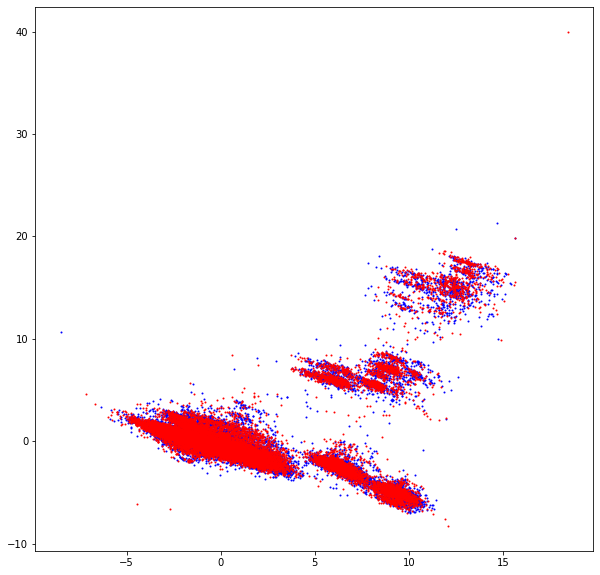

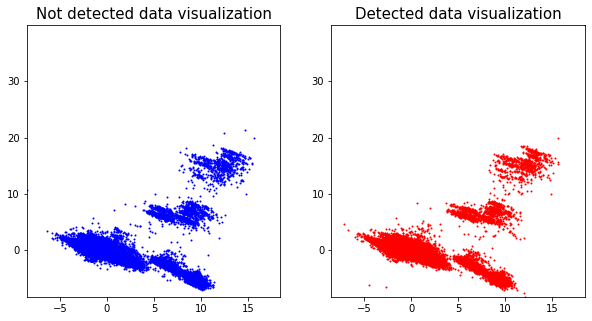

In [79]:
# Lets visually look at the positive and negative predictions

model = PCA(n_components=2)

train_pca_visual = np.array(model.fit_transform(normalized_train_features))

# when train_label == 1, then malware was detected
# when train_label == 0, malware was NOT detected

plt.figure(figsize=(10,10))

plt.plot(train_pca_visual[:,0][train_labels==0], train_pca_visual[:,1][train_labels==0], 'bo', markersize=1)
plt.plot(train_pca_visual[:,0][train_labels==1], train_pca_visual[:,1][train_labels==1], 'ro', markersize=1)


plt.figure(figsize=(10,5))
for i in range(2):
    color = 'bo' if i == 0 else 'ro'
    title = "Not detected data visualization" if i == 0 else "Detected data visualization"
    plt.subplot(1, 2, i + 1)
    plt.plot(train_pca_visual[:,0][train_labels==i], train_pca_visual[:,1][train_labels==i], color, markersize=1)
    plt.title(title, fontsize = 15)
    plt.ylim(train_pca_visual[:,1].min(), train_pca_visual[:,1].max())
    plt.xlim(train_pca_visual[:,0].min(), train_pca_visual[:,0].max())


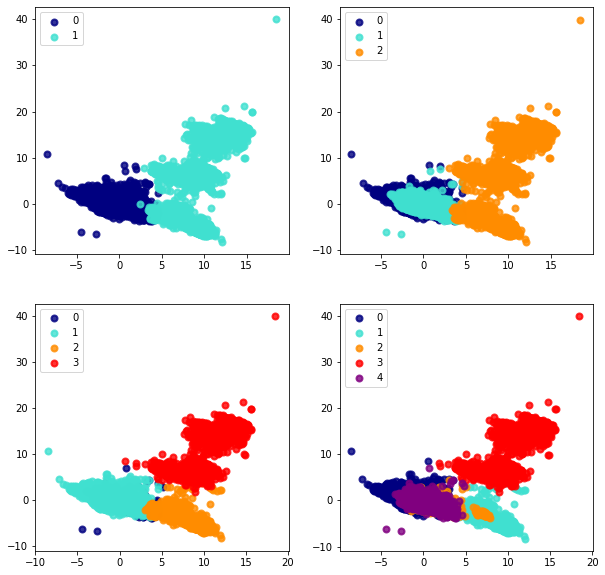

In [80]:
# Apply k-means + PCA + plot

from sklearn.cluster import KMeans

plot_data_length = 200000
colors = ['navy', 'turquoise', 'darkorange', 'red', 'purple', 'green', 'black']

fig, ax = plt.subplots(2,2,figsize=(10,10))

for k in range(2,6):
    # Fit the training data to a k-means clustering estimator model
    kmeans = KMeans(n_clusters=k).fit(train_pca[:plot_data_length])

    # Retrieve the labels assigned to each training sample
    kmeans_y = kmeans.labels_

    for color, cat in zip(colors, range(k)):
        p = ax[0 if k < 4 else 1,k % 2]
        p.scatter(train_pca[:plot_data_length][kmeans_y==cat, 0],
            train_pca[:plot_data_length][kmeans_y==cat, 1],
            color=color, alpha=.8, lw=2, label=cat)
        p.legend(loc='best', shadow=False, scatterpoints=1)


In [81]:
# Trying logistic regression and PCA
# The accuracy score would be 0.562275

solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

for s in solvers:
    # instantiate the model
    logreg = LogisticRegression(solver=s)

    # fit the model with data
    logreg.fit(train_pca, train_labels)

    # store the predicted response values
    y_pred = logreg.predict(test_pca)
    logreg_accuracy_score = accuracy_score(test_labels, y_pred)

    print('PCA =', train_pca.shape[1], s, 'logreg_accuracy_score', logreg_accuracy_score)

PCA = 10 newton-cg logreg_accuracy_score 0.56475
PCA = 10 lbfgs logreg_accuracy_score 0.5647777777777778
PCA = 10 liblinear logreg_accuracy_score 0.56475
PCA = 10 sag logreg_accuracy_score 0.5647777777777778
PCA = 10 saga logreg_accuracy_score 0.5647777777777778


In [82]:
# Trying logistic regression with regularized data
# The accuracy score would be 0.607825

solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

for s in solvers:
    # instantiate the model
    logreg = LogisticRegression(solver=s)

    # fit the model with data
    logreg.fit(normalized_train_features, train_labels)

    # store the predicted response values
    y_pred = logreg.predict(normalized_test_features)
    logreg_accuracy_score = accuracy_score(test_labels, y_pred)

    print('Features', normalized_train_features.shape[1], s, 'logreg_accuracy_score', logreg_accuracy_score)

Features 103 newton-cg logreg_accuracy_score 0.60775
Features 103 lbfgs logreg_accuracy_score 0.6077222222222223
Features 103 liblinear logreg_accuracy_score 0.60775
Features 103 sag logreg_accuracy_score 0.6074166666666667
Features 103 saga logreg_accuracy_score 0.6072777777777778


In [83]:
algorithms = {
    "HistGradientBoosting": ske.HistGradientBoostingClassifier(random_state=123),
    "DecisionTree": tree.DecisionTreeClassifier(max_depth=10,random_state=123),
    "RandomForest": ske.RandomForestClassifier(n_estimators=50,random_state=123),
    "GradientBoosting": ske.GradientBoostingClassifier(n_estimators=50,random_state=123),
    "AdaBoost": ske.AdaBoostClassifier(n_estimators=200,random_state=123),
    "Neural Net MLP": MLPClassifier(random_state=123),
}

In [84]:
results = {}
print('Testing algorithms using original dataset...')
print()
for algo in algorithms:
    clf = algorithms[algo]
    clf.fit(train_features, train_labels)
    score = clf.score(test_features, test_labels)
    print("%s : %f %%" % (algo, score*100))
    results[algo] = score
    
winner = max(results, key=results.get)
print()
print(f'Winning algorithm is {winner} with a {results[winner]*100}% accuracy')

Testing algorithms using original dataset...

HistGradientBoosting : 64.163889 %
DecisionTree : 61.477778 %
RandomForest : 62.208333 %
GradientBoosting : 62.294444 %
AdaBoost : 62.344444 %
Neural Net MLP : 49.669444 %

Winning algorithm is HistGradientBoosting with a 64.16388888888889% accuracy


In [85]:
results = {}
print('Testing algorithms using normalized original dataset...')
print()
for algo in algorithms:
    clf = algorithms[algo]
    clf.fit(normalized_train_features, train_labels)
    score = clf.score(normalized_test_features, test_labels)
    print("%s : %f %%" % (algo, score*100))
    results[algo] = score
    
winner = max(results, key=results.get)
print()
print(f'Winning algorithm is {winner} with a {results[winner]*100}% accuracy')

Testing algorithms using normalized original dataset...

HistGradientBoosting : 64.163889 %
DecisionTree : 61.505556 %
RandomForest : 62.461111 %
GradientBoosting : 62.275000 %
AdaBoost : 62.200000 %
Neural Net MLP : 60.913889 %

Winning algorithm is HistGradientBoosting with a 64.16388888888889% accuracy


In [86]:
results = {}
print('Testing algorithms using PCA...')
print()
for algo in algorithms:
    clf = algorithms[algo]
    clf.fit(train_pca, train_labels)
    score = clf.score(test_pca, test_labels)
    print("%s : %f %%" % (algo, score*100))
    results[algo] = score
    
winner = max(results, key=results.get)
print()
print(f'Winning algorithm is {winner} with a {results[winner]*100}% accuracy')

Testing algorithms using PCA...

HistGradientBoosting : 58.377778 %
DecisionTree : 56.394444 %
RandomForest : 57.841667 %
GradientBoosting : 57.580556 %
AdaBoost : 57.175000 %
Neural Net MLP : 58.494444 %

Winning algorithm is Neural Net MLP with a 58.49444444444445% accuracy


In [87]:
from sklearn.metrics import roc_curve, auc

clf = ske.HistGradientBoostingClassifier(random_state=123)
clf.fit(normalized_train_features, train_labels)
score = clf.score(normalized_test_features, test_labels)
predicted = clf.predict(normalized_test_features)

false_positive_rate, true_positive_rate, thresholds = roc_curve(test_labels, predicted)
roc_auc = auc(false_positive_rate, true_positive_rate)
print(roc_auc, false_positive_rate, true_positive_rate, thresholds)

0.6417487418003971 [0.         0.37459301 1.        ] [0.        0.6580905 1.       ] [2 1 0]


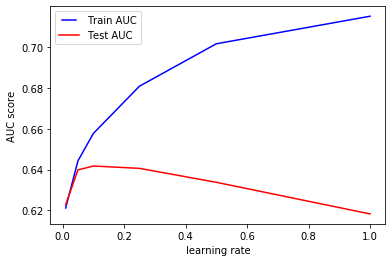

In [88]:
# Playing with learning rate
learning_rates = [1, 0.5, 0.25, 0.1, 0.05, 0.01]

train_results = []
test_results = []

for eta in learning_rates:
   model = ske.HistGradientBoostingClassifier(random_state=123,learning_rate=eta)
   model.fit(normalized_train_features, train_labels)   
   train_pred = model.predict(normalized_train_features)  

   false_positive_rate, true_positive_rate, thresholds = roc_curve(train_labels, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
    
   test_pred = model.predict(normalized_test_features)   
   false_positive_rate, true_positive_rate, thresholds = roc_curve(test_labels, test_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D

line1, = plt.plot(learning_rates, train_results, 'b', label='Train AUC')
line2, = plt.plot(learning_rates, test_results, 'r', label='Test AUC')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('learning rate')
plt.show()

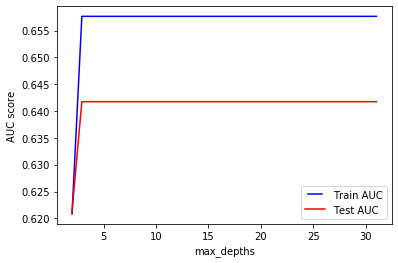

In [89]:
# Playing with max depth
max_depths = np.linspace(2, 31, 32, endpoint=True)

train_results = []
test_results = []

for max_depth in max_depths:
   model = ske.HistGradientBoostingClassifier(random_state=123,max_depth=max_depth)
   model.fit(normalized_train_features, train_labels)   
   train_pred = model.predict(normalized_train_features)  

   false_positive_rate, true_positive_rate, thresholds = roc_curve(train_labels, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
    
   test_pred = model.predict(normalized_test_features)   
   false_positive_rate, true_positive_rate, thresholds = roc_curve(test_labels, test_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D

line1, = plt.plot(max_depths, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_depths, test_results, 'r', label='Test AUC')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('max_depths')
plt.show()


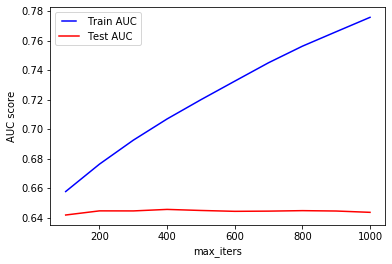

In [90]:
# Playing with max iterations
max_iters = np.linspace(100, 1000, 10, endpoint=True)

train_results = []
test_results = []

for max_iter in max_iters:
   model = ske.HistGradientBoostingClassifier(random_state=123,max_iter=int(max_iter))
   model.fit(normalized_train_features, train_labels)   
   train_pred = model.predict(normalized_train_features)  

   false_positive_rate, true_positive_rate, thresholds = roc_curve(train_labels, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
    
   test_pred = model.predict(normalized_test_features)   
   false_positive_rate, true_positive_rate, thresholds = roc_curve(test_labels, test_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D

line1, = plt.plot(max_iters, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_iters, test_results, 'r', label='Test AUC')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('max_iters')
plt.show()


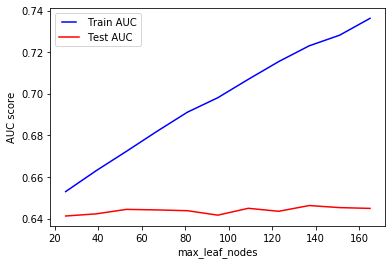

In [91]:
# Playing with max leaf nodes
max_leaf_nodes = np.linspace(25, 165, 11, endpoint=True)

train_results = []
test_results = []

for max_leaf_node in max_leaf_nodes:
   model = ske.HistGradientBoostingClassifier(random_state=123,max_leaf_nodes=int(max_leaf_node))
   model.fit(normalized_train_features, train_labels)   
   train_pred = model.predict(normalized_train_features)  

   false_positive_rate, true_positive_rate, thresholds = roc_curve(train_labels, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
    
   test_pred = model.predict(normalized_test_features)   
   false_positive_rate, true_positive_rate, thresholds = roc_curve(test_labels, test_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D

line1, = plt.plot(max_leaf_nodes, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_leaf_nodes, test_results, 'r', label='Test AUC')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('max_leaf_nodes')
plt.show()


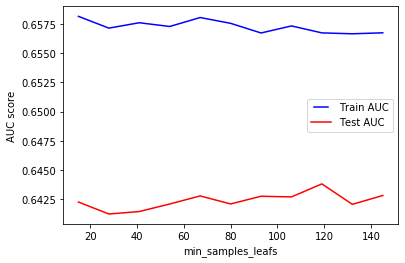

In [92]:
# Playing with min sample leafs
min_samples_leafs = np.linspace(15, 145, 11, endpoint=True)

train_results = []
test_results = []

for min_samples_leaf in min_samples_leafs:
   model = ske.HistGradientBoostingClassifier(random_state=123,min_samples_leaf=int(min_samples_leaf))
   model.fit(normalized_train_features, train_labels)   
   train_pred = model.predict(normalized_train_features)  

   false_positive_rate, true_positive_rate, thresholds = roc_curve(train_labels, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
    
   test_pred = model.predict(normalized_test_features)   
   false_positive_rate, true_positive_rate, thresholds = roc_curve(test_labels, test_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D

line1, = plt.plot(min_samples_leafs, train_results, 'b', label='Train AUC')
line2, = plt.plot(min_samples_leafs, test_results, 'r', label='Test AUC')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min_samples_leafs')
plt.show()


### Extra code